# Imports

In [1]:

import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import warnings
import data_func.read_data as read_data
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")



# Load datasets

In [2]:
import data_func.read_data as read_data

dataframes = read_data.get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = read_data.get_test_data()


In [3]:
XTRA = X_frames_train[0]
XTRB = X_frames_train[1]
XTRC = X_frames_train[2]

YA = Y_frames_train[0]
YB = Y_frames_train[1]
YC = Y_frames_train[2]


In [4]:
print("A: \n", len(XTRA))
ind = XTRA[(XTRA['date_forecast'] == pd.to_datetime('2022-10-21 00:00:00'))].index
print(ind)
XTRA = XTRA.drop(ind).reset_index(drop=True)
print(len(XTRA))



A: 
 136245
Int64Index([118664], dtype='int64')
136244


In [5]:
print("B: \n", len(XTRB))
ind = XTRB[(XTRB['date_forecast'] == pd.to_datetime('2022-05-02 21:00:00'))].index
print(ind)
XTRB = XTRB.drop(ind).reset_index(drop=True)
print(len(XTRB))

print("C: \n",len(XTRC))
ind = XTRC[(XTRC['date_forecast'] == pd.to_datetime('2022-04-25 21:00:00'))].index
print(ind)
XTRC = XTRC.drop(ind).reset_index(drop=True)
print(len(XTRC))


B: 
 134505
Int64Index([116916], dtype='int64')
134504
C: 
 134401
Int64Index([116244], dtype='int64')
134400


# Data clean up

[56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1

<Axes: title={'center': 'Target C Clean'}, xlabel='time'>

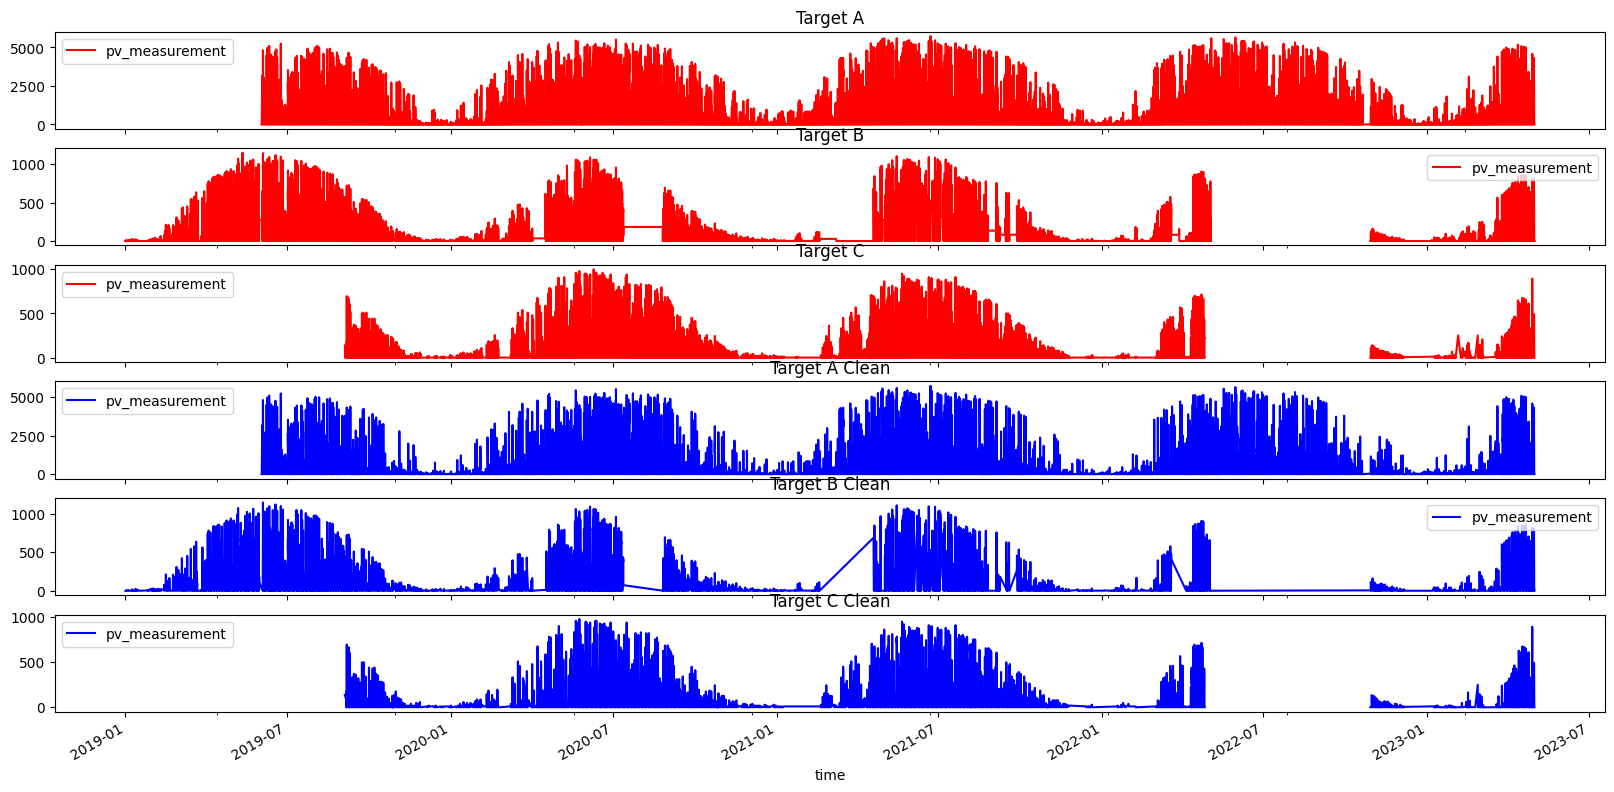

In [6]:
def fix_y_holes(y: pd.DataFrame) -> pd.DataFrame:
    Y = y
    drop_val = None
    zero_counter = 0
    index_dropper = []
    for i in range(1, len(Y)-4): # Since we match on 4 consecutive values.
        if Y['pv_measurement'].iloc[i] != 0:
            if zero_counter > 23:
                zero_list = list(range(i-zero_counter, i))
                index_dropper.extend(zero_list)
                zero_counter = 0
            if (Y['pv_measurement'].iloc[i] == Y['pv_measurement'].iloc[i+1] and Y['pv_measurement'].iloc[i+1] == Y['pv_measurement'].iloc[i+2] and Y['pv_measurement'].iloc[i+2] == Y['pv_measurement'].iloc[i+3]):
                drop_val = Y['pv_measurement'].iloc[i]
        if Y['pv_measurement'].iloc[i] == 0:
            zero_counter += 1
        if Y['pv_measurement'].iloc[i] == drop_val:
            index_dropper.append(i)
        else:
            if drop_val != None:
                drop_val = None
    print(index_dropper)
    return Y.drop(index_dropper)
    
import matplotlib.pylab as plt
fig, axs = plt.subplots(6, 1, figsize=(20, 10), sharex=True)
YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target A', color='red')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Target B', color='red')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='Target C', color='red')


YA = fix_y_holes(YA)
YB = fix_y_holes(YB)
YC = fix_y_holes(YC)

YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[3], title='Target A Clean', color='blue')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[4], title='Target B Clean', color='blue')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[5], title='Target C Clean', color='blue')



# Data Aggregation

In [7]:
# making shure that target values line up with x_values
import data_func.aggregation as data_agg

categorical_col = ['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx']

def aggregate_correct_x(x: pd.DataFrame) -> pd.DataFrame:
   '''
   Takes a given dataframe and returns an aggregated dataframe based on selected categorical functions. 
   Assumes grouping of 4.
   '''
   categorical = x[["date_forecast"] + categorical_col]
   mean = x.drop(columns=categorical_col)

   categorical = data_agg.gen_agg(categorical, agg_type=data_agg.stocastic_median, merge_on = 'first')
   mean = data_agg.gen_agg(mean, "mean", merge_on = 'first')

   return pd.merge(categorical, mean, on="date_forecast")

def data_allign(x_train, y_train):

  y_train.dropna(inplace=True)
  x_train = aggregate_correct_x(x_train)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train



X_train = [XTRA, XTRB, XTRC]
Y_train = [YA, YB, YC]

for i in range(len(X_train)):
    X_train[i], Y_train[i] = data_allign(X_train[i], Y_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = aggregate_correct_x(X_frames_test[j])


In [8]:
#Verify length matches
for x in range(len(X_train)):
    print("x,y: ", len(X_train[x]), len(Y_train[x]))


x,y:  18071 18071
x,y:  12443 12443
x,y:  10129 10129


In [9]:
X_train[0].tail()


,date_forecast,dew_or_rime:idx,precip_type_5min:idx,is_day:idx,is_in_shadow:idx,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,...,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,estimation_calc_forecast_difference
18066,2023-04-30 19:00:00,0,0,0,1,4.55,1.27650,1674.199951,84464.945312,4.225,...,0.000,275.024994,96.699997,23417.074219,5.175,4.800,1.925,0.0,1.0,44545.0
18067,2023-04-30 20:00:00,0,0,0,1,4.50,1.27975,1762.400024,2270.875000,0.000,...,0.000,274.650024,94.525002,21084.050781,4.650,4.025,2.300,0.0,1.0,48145.0
18068,2023-04-30 21:00:00,0,0,0,1,4.50,1.28100,1696.650024,0.000000,0.000,...,0.000,274.524994,95.675003,20792.500000,4.450,3.575,2.600,0.0,1.0,51745.0
18069,2023-04-30 22:00:00,0,0,0,1,4.50,1.28100,1353.400024,0.000000,0.000,...,0.100,274.325012,98.875000,14158.099609,4.100,3.175,2.550,0.0,1.0,55345.0
18070,2023-04-30 23:00:00,0,0,0,1,4.50,1.28100,1626.574951,0.000000,0.000,...,0.075,274.225006,99.699997,11872.299805,3.750,2.725,2.550,0.0,1.0,58945.0


# Feature engineering

In [10]:
import data_func.timeseasonality as DTS
import data_func.one_hot_encoding as OHE
import data_func.date_forecast as DF

def more_features(df: pd.DataFrame) -> pd.DataFrame:
    # Convert the 'date_forecast' to datetime and set it as index
    df['date_forecast'] = pd.to_datetime(df['date_forecast'])
    df.set_index('date_forecast', inplace=True)
    df.sort_index(inplace=True)

    # Now apply the rolling function
    df['max_air_density_3h'] = df['air_density_2m:kgm3'].rolling('3h').max()
    df['min_air_density_3h'] = df['air_density_2m:kgm3'].rolling('3h').min()
    df['total_solar_rad_1h'] = df['direct_rad_1h:J'] + df['diffuse_rad_1h:J']
    df['total_wind_speed_10m'] = (df['wind_speed_u_10m:ms']**2 + df['wind_speed_v_10m:ms']**2)**0.5
    df['total_snow_1h'] = df[['fresh_snow_1h:cm', 'snow_melt_10min:mm']].sum(axis=1)
    df['pressure_variation_3h'] = df['sfc_pressure:hPa'].diff(periods=3)
    return df

for i in range(len(X_train)):
    X_train[i] = DTS.append_seasonal_columns(X_train[i])
    X_train[i] = DF.date_forecast_columns(X_train[i])

for i in range(len(X_frames_test)):
    X_frames_test[i] = DTS.append_seasonal_columns(X_frames_test[i])
    X_frames_test[i] = DF.date_forecast_columns(X_frames_test[i])    
 

# THIS SECTION CAN ONLY WORK IF THE PREVIOUS AGGREGATION IS DONE INDIVIDUALLY FOR CATEGORICAL DATA
# import data_func.one_hot_encoding as OHE

def fix_categorical(train: pd.DataFrame, test: pd.DataFrame):
    temp = pd.concat([train, test], ignore_index=True)
    index_train = temp[(temp['date_forecast'] < test['date_forecast'].iloc[0])].index
    return temp.drop(index_train)

OH_columns = ['dew_or_rime:idx', 'precip_type_5min:idx']

for i in range(len(X_frames_test)):
    X_train[i] = OHE.one_hot_encode(X_train[i],OH_columns)
    X_frames_test[i] = OHE.one_hot_encode(X_frames_test[i], OH_columns)
    X_frames_test[i] = fix_categorical(X_train[i], X_frames_test[i])
    X_train[i] = more_features(X_train[i])
    X_frames_test[i] = more_features(X_frames_test[i])


    # kommenter dusse=
    # X_train[i].drop(columns=['date_forecast'], inplace=True)
    # X_frames_test[i].drop(columns=['date_forecast'], inplace=True)


# Data cleaning

In [11]:
# Show null values for all training sets

count_a = X_train[0].isna().sum()
count_b = X_train[1].isna().sum()
count_c = X_train[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,3525,2104,2289
cloud_base_agl:m,1322,910,873
snow_density:kgm3,17719,12166,10116
pressure_variation_3h,3,3,3


In [12]:
# Show null values for all test sets

count_a = X_frames_test[0].isna().sum()
count_b = X_frames_test[1].isna().sum()
count_c = X_frames_test[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,188,180,202
cloud_base_agl:m,70,65,88
snow_density:kgm3,720,720,720
dew_or_rime:idx_-1,720,720,0
precip_type_5min:idx_2,720,720,720
precip_type_5min:idx_3,720,720,720
pressure_variation_3h,3,3,3


In [13]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 20000, "cloud_base_agl:m": 20000}

for i in range(len(X_train)):
    X_train[i].drop(columns=['snow_density:kgm3', 'elevation:m', 'year'], inplace=True)
    X_frames_test[i].drop(columns=['snow_density:kgm3', 'elevation:m', 'year'], inplace=True)
    X_train[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)




In [14]:

print(X_train[0]['estimated'])


date_forecast
2019-06-02 22:00:00    0.0
2019-06-02 23:00:00    0.0
2019-06-03 00:00:00    0.0
2019-06-03 01:00:00    0.0
2019-06-03 02:00:00    0.0
                      ... 
2023-04-30 19:00:00    1.0
2023-04-30 20:00:00    1.0
2023-04-30 21:00:00    1.0
2023-04-30 22:00:00    1.0
2023-04-30 23:00:00    1.0
Name: estimated, Length: 18071, dtype: float64


In [15]:

def combine_features(df, listOfFeaturesToCombine):
    for features in listOfFeaturesToCombine:
        new_col_name = features[0] + '_mean'
        df[new_col_name] = df[features].mean(axis=1)
    return df

listOfFeaturesToCombine = [['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa'],
                            ["diffuse_rad:W", "direct_rad:W"], 
                           ['effective_cloud_cover:p', 'total_cloud_cover:p']
                    ]
for i in range(len(X_train)):
    X_train[i] = combine_features(X_train[i], listOfFeaturesToCombine)
    X_frames_test[i] = combine_features(X_frames_test[i], listOfFeaturesToCombine)
X_train[0].describe().transpose()

# top_10_worst_features = ['precip_type_5min:idx_5', 'wind_speed_w_1000hPa:ms', 'dew_or_rime:idx_-1', 'precip_type_5min:idx_2', 'dew_or_rime:idx_1', 'snow_drift:idx', 'dew_or_rime:idx_0', 'prob_rime:p', 'precip_type_5min:idx_3', 'fresh_snow_1h:cm',
#                          'fresh_snow_3h:cm', 'snow_melt_10min:mm', 'fresh_snow_6h:cm', 'snow_depth:cm', 'precip_type_5min:idx_1',
#                          'rain_water:kgm2', 'fresh_snow_12h:cm']
# top_5_worst_features = ['snow_drift:idx', 'dew_or_rime:idx_-1', 'dew_or_rime:idx_0', 'precip_type_5min:idx_5', 'precip_type_5min:idx_2', 
#                         'wind_speed_u_10m:ms', 'wind_speed_w_1000hPa:ms','wind_speed_v_10m:ms'
#                         ]
# for i in range(len(X_train)):
#     X_train[i].drop(columns=top_5_worst_features, inplace=True)
#     X_frames_test[i].drop(columns=top_5_worst_features, inplace=True)

# for i in range(len(X_train)):
#     X_train[i].drop(columns=top_10_worst_features, inplace=True)
#     X_frames_test[i].drop(columns=top_10_worst_features, inplace=True)


# for i in range(len(X_train)):
#     X_train[i]['diffuse_rad:W_mean_prev_hour'] = X_train[i]['diffuse_rad:W_mean'].shift(1)
#     X_train[i]['diffuse_rad_1h:J_mean_prev_hour'] = X_train[i]['diffuse_rad_1h:J_mean'].shift(1)
#     X_frames_test[i]['diffuse_rad:W_mean_prev_hour'] = X_frames_test[i]['diffuse_rad:W_mean'].shift(1)
#     X_frames_test[i]['diffuse_rad_1h:J_mean_prev_hour'] = X_frames_test[i]['diffuse_rad_1h:J_mean'].shift(1)




,count,mean,std,min,25%,50%,75%,max
is_day:idx,18071.0,0.634442,0.4816,0.0,0.0,1.0,1.0,1.0
is_in_shadow:idx,18071.0,0.376736,0.484581,0.0,0.0,0.0,1.0,1.0
absolute_humidity_2m:gm3,18071.0,7.061308,2.840138,0.9,4.75,7.025,9.0,17.35
air_density_2m:kgm3,18071.0,1.243987,0.035809,1.145,1.21975,1.241,1.2675,1.40525
ceiling_height_agl:m,18071.0,6450.599609,7093.13916,28.0,1346.224976,2953.5,8531.549805,20000.0
...,...,...,...,...,...,...,...,...
total_snow_1h,18071.0,0.005153,0.078004,0.0,0.0,0.0,0.0,3.55
pressure_variation_3h,18068.0,0.001479,3.578179,-35.200073,-0.850037,0.0,0.849976,40.150024
msl_pressure:hPa_mean,18071.0,1006.070496,11.872775,941.887512,998.868713,1007.099976,1013.949951,1038.943726
diffuse_rad:W_mean,18071.0,66.710594,90.095024,0.0,0.0,20.275,108.881248,386.637512


In [16]:
from data_func.combine_all_frames import combine_all_frames

def combine_series(series: [pd.Series]) -> pd.Series:
    combined = pd.concat(series)
    combined.reset_index(drop=True, inplace=True)
    return combined

X_comb = combine_all_frames(X_train)

NYA=(Y_train[0]-Y_train[0].mean())/Y_train[0].std()
NYB=(Y_train[1]-Y_train[1].mean())/Y_train[1].std()
NYC=(Y_train[2]-Y_train[2].mean())/Y_train[2].std()


In [17]:
print(NYA.head(), Y_train[0].head())


0   -0.666864
1   -0.666864
2   -0.666864
3   -0.666864
4   -0.652230
Name: pv_measurement, dtype: float64 0     0.00
1     0.00
2     0.00
3     0.00
4    19.36
Name: pv_measurement, dtype: float64


In [18]:
NoYA = (NYA * Y_train[0].std())+Y_train[0].mean()
NoYA.head()

0     0.00
1     0.00
2     0.00
3     0.00
4    19.36
Name: pv_measurement, dtype: float64

In [19]:
Y_comb = combine_series([NYA, NYB, NYC])


In [20]:
Y_comb.reset_index(drop=True, inplace=True)
Y_comb.tail()

40638   -0.433639
40639   -0.664875
40640   -0.679032
40641   -0.679032
40642   -0.679032
Name: pv_measurement, dtype: float64

# Training the model

In [21]:



# Use params from hyperparameter tuning using optuna
params_a = {'random_state': 42, 'learning_rate': 0.039975576144155645, 'depth': 9, 'subsample': 0.4504678933801176, 'colsample_bylevel': 0.9773225861097778, 'min_data_in_leaf': 90}
params_b = {'random_state': 42, 'learning_rate': 0.023765834908014156, 'depth': 10, 'subsample': 0.8298593330195755, 'colsample_bylevel': 0.6060393047650714, 'min_data_in_leaf': 61}
params_c = {'random_state': 42, 'learning_rate': 0.060183973978509046, 'depth': 10, 'subsample': 0.28819995411353627, 'colsample_bylevel': 0.39818319507473743, 'min_data_in_leaf': 77}

# # Hypertuned params, but worse :(
# params_a = {'random_state': 42, 'learning_rate': 0.09566223811599815, 'depth': 7, 'subsample': 0.960801961471582, 'colsample_bylevel': 0.6043383106745279, 'min_data_in_leaf': 78}
# params_b = {'random_state': 42, 'learning_rate': 0.04250298579274471, 'depth': 10, 'subsample': 0.5902141253689043, 'colsample_bylevel': 0.4702544263427683, 'min_data_in_leaf': 87}
# params_c = {'random_state': 42, 'learning_rate': 0.008810167623455675, 'depth': 10, 'subsample': 0.8621321557173095, 'colsample_bylevel': 0.6774949043850594, 'min_data_in_leaf': 25}

model_a = CatBoostRegressor(**params_a)

model_a.fit(X_comb, Y_comb)



0:	learn: 0.9678659	total: 70.8ms	remaining: 1m 10s
1:	learn: 0.9370408	total: 85ms	remaining: 42.4s
2:	learn: 0.9075763	total: 102ms	remaining: 33.9s
3:	learn: 0.8798300	total: 124ms	remaining: 30.9s
4:	learn: 0.8532510	total: 141ms	remaining: 28.2s
5:	learn: 0.8279865	total: 160ms	remaining: 26.6s
6:	learn: 0.8035818	total: 176ms	remaining: 25s
7:	learn: 0.7803509	total: 195ms	remaining: 24.2s
8:	learn: 0.7581439	total: 208ms	remaining: 22.9s
9:	learn: 0.7369183	total: 225ms	remaining: 22.3s
10:	learn: 0.7170641	total: 244ms	remaining: 22s
11:	learn: 0.6982175	total: 261ms	remaining: 21.5s
12:	learn: 0.6804248	total: 279ms	remaining: 21.1s
13:	learn: 0.6630557	total: 296ms	remaining: 20.9s
14:	learn: 0.6469048	total: 309ms	remaining: 20.3s
15:	learn: 0.6310754	total: 324ms	remaining: 19.9s
16:	learn: 0.6163186	total: 345ms	remaining: 20s
17:	learn: 0.6022309	total: 359ms	remaining: 19.6s
18:	learn: 0.5889997	total: 377ms	remaining: 19.5s
19:	learn: 0.5763584	total: 393ms	remaining: 1

# Evaluate prediction

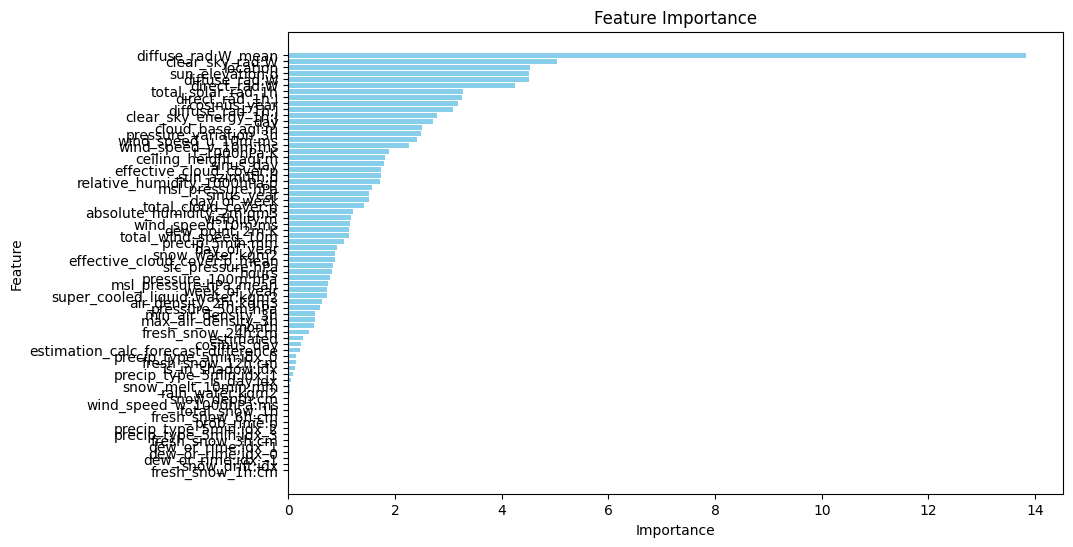

In [22]:
import matplotlib.pyplot as plt

feature_importance = model_a.get_feature_importance()
# Create a DataFrame to store feature names and their importance scores
importance_df = pd.DataFrame({'Feature': X_comb.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance scores in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot to visualize feature importance

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
plt.show()


In [23]:
worst_features = importance_df.sort_values(by='Importance', ascending=True).head(5)['Feature'].tolist()
print(worst_features)


['fresh_snow_1h:cm', 'dew_or_rime:idx_1', 'snow_drift:idx', 'dew_or_rime:idx_-1', 'dew_or_rime:idx_0']


# Make predictions

# Create submission

In [24]:
def upscale(val, location: int):
    return (val * Y_train[location].std())+Y_train[location].mean()

#predictions before full training
x_test_comb = combine_all_frames(X_frames_test)
pred = model_a.predict(x_test_comb)

a_ind_test = x_test_comb[x_test_comb['location'] == 0].index
b_ind_test = x_test_comb[x_test_comb['location'] == 1].index
c_ind_test = x_test_comb[x_test_comb['location'] == 2].index

pred_a = upscale(pred[a_ind_test], 0)
pred_b = upscale(pred[b_ind_test], 1)
pred_c = upscale(pred[c_ind_test], 2)

y_pred = np.concatenate((pred_a, pred_b, pred_c), axis=0)

print(len(y_pred))





2160


In [26]:
for i in range(len(y_pred)):
    if i < 720:
        if y_pred[i] < 20: 
            y_pred[i] = 0
    else:
        if y_pred[i] < 10: 
            y_pred[i] = 0


In [27]:
y_test_pred = y_pred

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submissions/submission_cat_y_norm.csv', index=False)


(2160,)
(2160,)


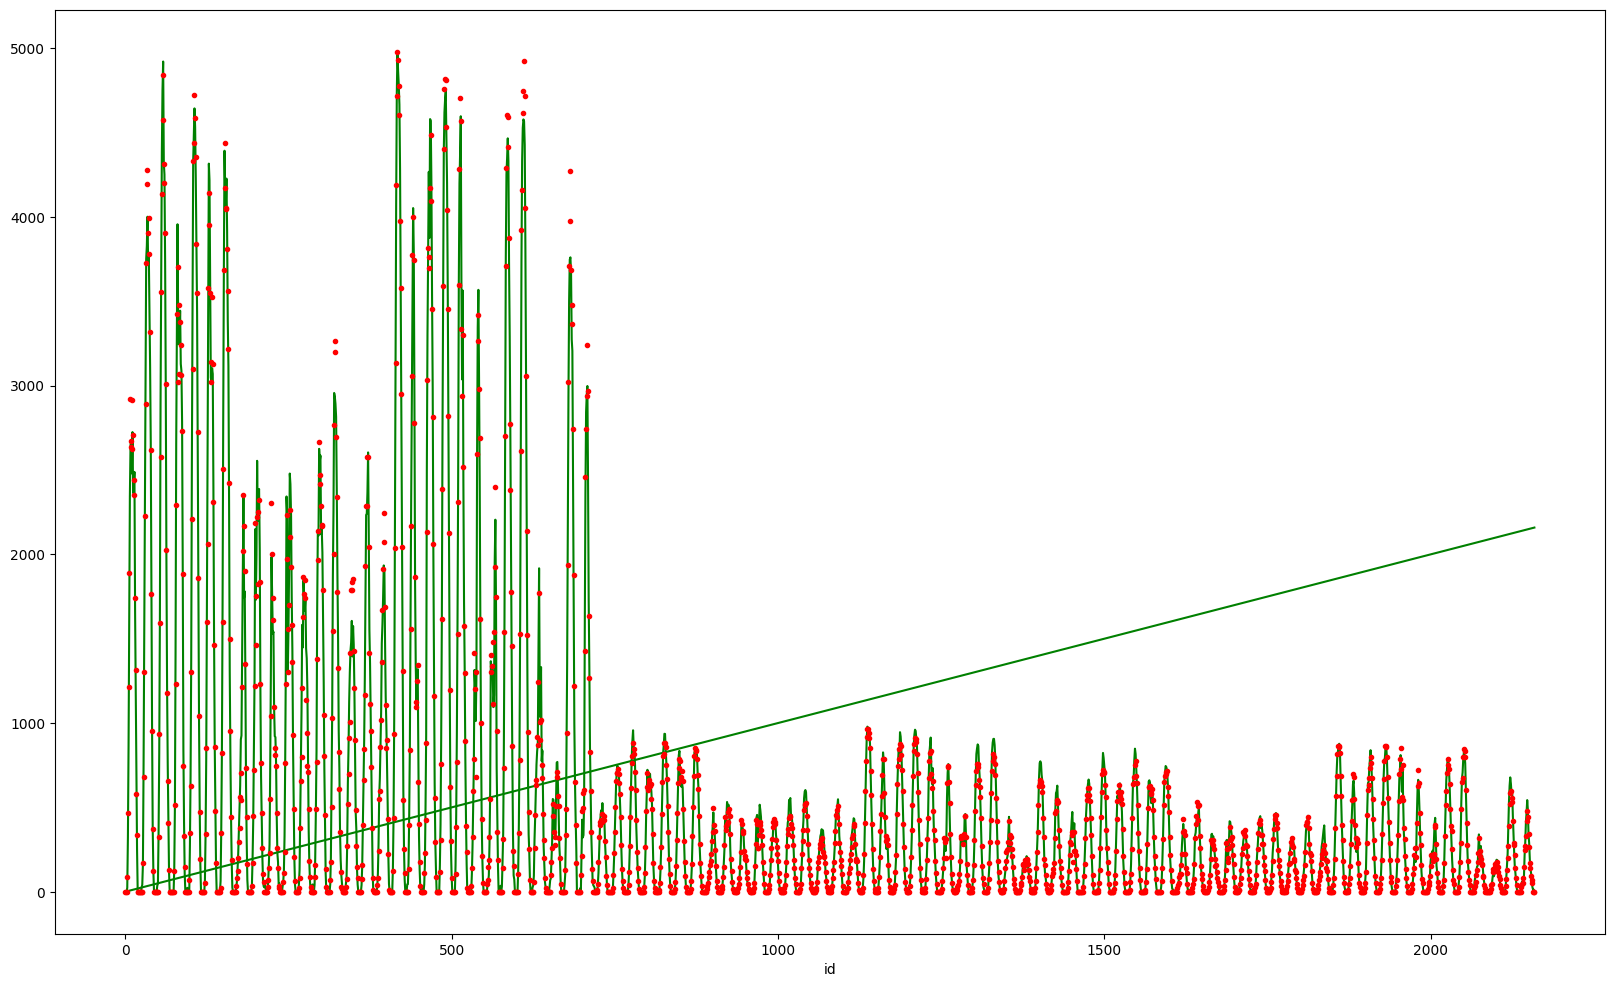

In [29]:
best_submission = pd.read_csv('./submissions/submission_cat_148LESSSSGO.csv')
second_best_sub = pd.read_csv('./submissions/submission_cat_y_norm.csv')

print(y_pred.shape)
print(best_submission['prediction'].shape)
plt.figure(figsize=(20,12))

plt.plot(second_best_sub, 'g')
plt.plot(best_submission['prediction'], 'r.')
plt.xlabel("id")
plt.show()


In [ ]:
dist = best_submission['prediction'] - second_best_sub['prediction']

plt.figure(figsize=(20,12))
plt.plot(dist)
